In [50]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [51]:
# Load in all of the fits images in the directory and sort it

image_list = glob.glob("/Users/hwhite/Dropbox/Testdata_Target_E/ASASJ030015-0459.7_20190913_B/*e91.fits.fz")
image_list.sort()

In [52]:
#Make some useful lists of values to track/record
obstime = []
Bmag = []
Vmag = []
Bmag_e = []
Vmag_e = []
avg_offset = []

In [53]:
# Input the information for the calibration stars identified
# in the previous notebook for batch processing of all of the images

zpt_instrumental = 25.

tar_ra = 45.064
tar_dec = -4.995
tar_color = 'yellow'
ref_ra = [44.93200, 45.00766, 45.11216, 45.12369]
ref_dec = [-5.03533, -4.79669, -4.91007, -4.93852]
ref_colors = ['red','cyan', 'green', 'blue']
ref_mag = [11.275, 12.093, 13.005, 14.65]

In [54]:
# Let's calculate the target mag in each frame

for frame in image_list:
    hdu = fits.open(frame)

    # Grab the actual science data based on above.
    sci_data = hdu[1]
    sci_hdr = sci_data.header
    obstime.append(sci_hdr['UTSTART'])

    # Background estimation:
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data.data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data.data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

    # Actually do the photometry and put it in a table.
    # Using the WCS info from each img's header, calculate positions of the calibration stars
    w = wcs.WCS(sci_hdr)
    ref_xcoords, ref_ycoords = w.all_world2pix(ref_ra,ref_dec,1)
    ref_positions = np.transpose((ref_xcoords, ref_ycoords))
    ref_apertures = CircularAperture(ref_positions, r=24.)
    ref_phot = aperture_photometry(sci_bkg, ref_apertures, error=error)
    
    # NOTE. By default photutils just actually gives a total number of counts in the apertures, not a magnitude.
    # Calculate instrumental magnitudes here and add them to the table 
    # Magnitudes will be calibrated with standard stars below.

    mag = -2.5*np.log10(ref_phot['aperture_sum']) + zpt_instrumental
    dmag = (2.5/np.log(10))*(ref_phot['aperture_sum_err']/ref_phot['aperture_sum'])
    
    ref_phot['mag'] = mag
    ref_phot['mag_err'] = dmag

    # Calibrate the photometry
    # Calculate zeropoint/offsets based on a set of standard stars.
    mag_measured = mag
    mag_known = src_mag

    # Calculate offsets and the standard deviation of the offset from each star.
    offsets = mag_known - mag_measured
    offset = np.mean(offsets)
    avg_offset.append(offset)
    doffset = np.std(offsets)
    
    # Do photometry on the variable target!!
    tar_xcoord, tar_ycoord  = w.all_world2pix(tar_ra,tar_dec,1)
    tar_position = np.transpose((tar_xcoord, tar_ycoord))
    
    tar_aperture = CircularAperture(tar_position, r=24.)
    tar_phot = aperture_photometry(sci_bkg, tar_aperture, error=error)
    
    tar_mag = -2.5*np.log10(tar_phot['aperture_sum']) + zpt_instrumental
    tar_dmag = (2.5/np.log(10))*(tar_phot['aperture_sum_err']/tar_phot['aperture_sum'])
    
    tar_phot['mag'] = tar_mag
    tar_phot['mag_err'] = tar_dmag
    
    cal_tar_mag = tar_phot['mag']+offset
    cal_tar_dmag = np.sqrt(tar_phot['mag_err']**2.+doffset**2.)
    
    Bmag.append(cal_tar_mag)
    Bmag_e.append(cal_tar_dmag)
    
    print(cal_tar_mag)

       mag        
------------------
12.885259132969358
       mag        
------------------
12.647057870571173
       mag        
------------------
12.476001011691249
      mag       
----------------
12.4801069099463
       mag        
------------------
12.542094201801913
       mag        
------------------
12.634746791898166
       mag        
------------------
13.078451316731654
       mag        
------------------
12.943382514893724
       mag        
------------------
13.097665334267893
       mag        
------------------
13.173636039448036
       mag        
------------------
13.177104809283131
       mag       
-----------------
13.14205315462597
       mag        
------------------
13.077486087872078


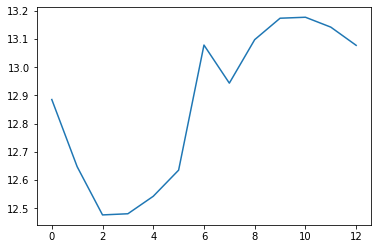

In [55]:
# # Make a rudimentary lightcurve
plt.plot(Bmag)
plt.show()